In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from statannotations.Annotator import Annotator
sns.set(style='ticks', font_scale=1)
import uncertainties


# Plot data related to the chemostat experiment

In [41]:
git_folder = Path('../..')
figure_folder = git_folder / 'Figures' /'chemostat'
figure_folder.mkdir(parents=True, exist_ok=True)
data_folder_1 = git_folder / 'data' / 'this_project' / '3_keio_strains_chemostat'

fn_chemostat_od = data_folder_1 / '3A_chemostat_OD.csv'
fn_chemostat_set_feed_rates = data_folder_1 / '3J_chemostat_set_feed_rates.csv'
fn_tubes = data_folder_1 / '3E_exometabolome_sucB_aceE_strains_OD.csv'
fn_tube_samples = data_folder_1 / '3F_exometabolome_sucB_aceE_strains_samples.csv'

fn_exometabolome_nM = data_folder_1 / '3I_exometabolome_rates.csv'
fn_exometabolome_counts = data_folder_1 / '3H_exometabolome_counts.csv'


In [3]:
tab10_cmap = sns.color_palette("tab10", 10)

set2 = sns.color_palette("Set2", 8)
strains_cmap = {
    'ΔaceE': tab10_cmap[1],
    'ΔsucB': tab10_cmap[8],
    'E. coli WT': tab10_cmap[0],
    'ΔaceE-M2':set2[3],
    'ΔaceE-M3':set2[0],
    'ΔaceE-M4':set2[6],
    'ΔsucB-M5':set2[5],
    'ΔsucB-M6':set2[2],
    'ΔsucB-M7':set2[7],
}

label_mapping = {
    'aceE-M2': 'ΔaceE-M2',
    'aceE-M3': 'ΔaceE-M3',
    'aceE-M4': 'ΔaceE-M4',
    'WT': 'E. coli WT',
    'aceE': 'ΔaceE',
    'sucB-M5': 'ΔsucB-M5',
    'sucB-M6': 'ΔsucB-M6',
    'sucB-M7': 'ΔsucB-M7',
    'sucB': 'ΔsucB',
}




# Plot chemostat OD

In [146]:
strain

'Strain = sucB'

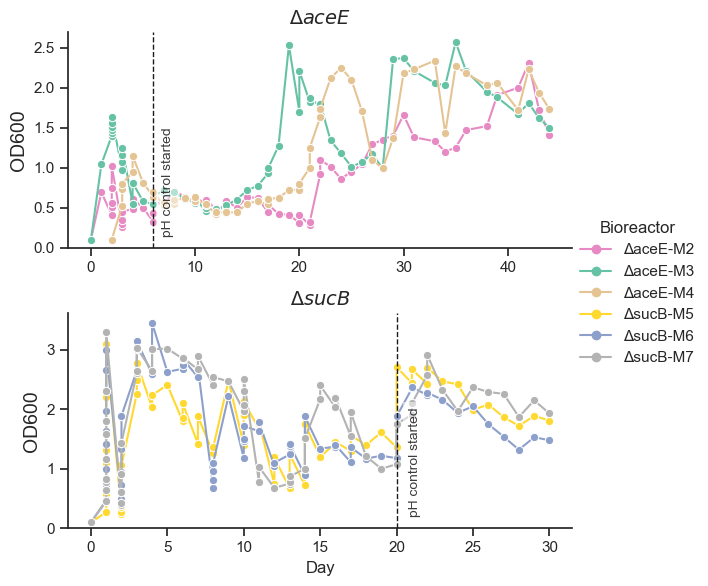

In [154]:
chemostat_od = pd.read_csv(fn_chemostat_od)
chemostat_od['Bioreactor'] = chemostat_od['Strain-Bioreactor'].map(label_mapping)
g = sns.relplot(data=chemostat_od, x='Day', y='OD', hue = 'Bioreactor', kind='line',
            aspect=2, marker = 'o', row = 'Strain', height=3, estimator=None,
            facet_kws={'sharex':False, 'sharey':False,}, palette=strains_cmap,)


axvline_dict = {
    'aceE':6,
    'sucB':20
}
for ax in g.axes.flat:
    strain = ax.get_title().split('=')[1].strip()  # Extract strain name from title
    if strain in axvline_dict:
        ax.set_ylim(0)
        ax.axvline(axvline_dict[strain], color='k', ls='--', lw=1)
        ax.text(axvline_dict[strain] + 0.8, 0.05, 'pH control started', rotation=90, transform=ax.get_xaxis_transform(),
                fontsize=10, va='bottom', ha='left', alpha=0.9, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none') )

g.set_titles(r"Δ${row_name}$", size = 14)  # Sets titles to only display the strain name
g.set_ylabels('OD600', size = 14)

plt.savefig(figure_folder / 'chemostat_OD.pdf', bbox_inches='tight')

# Plot chemostat feed rates

In [42]:
df_feed_rates = pd.read_csv(fn_chemostat_set_feed_rates)

In [123]:
df_feed_ratesL = df_feed_rates.melt(id_vars=['Time [h]'], var_name='Bioreactor', value_name='Feed rate [mL/h]', 
                                    value_vars=['aceE-M2', 'aceE-M3', 'aceE-M4', 'sucB-M5', 'sucB-M6', 'sucB-M7'])
df_feed_ratesL['Strain'] = df_feed_ratesL['Bioreactor'].str.split('-').str[0]


In [124]:
df_feed_ratesL.dropna(inplace=True)
df_feed_ratesL['Day'] = df_feed_ratesL['Time [h]'] / 24
df_feed_ratesL['Bioreactor'] = 'Δ' + df_feed_ratesL['Bioreactor']
df_feed_ratesL['Feed rate [/h]'] = df_feed_ratesL['Feed rate [mL/h]'] / 300

In [150]:
df_feed_rates[['aceE-M2', 'aceE-M3', 'aceE-M4', 'sucB-M5', 'sucB-M6', 'sucB-M7']].max()

aceE-M2    30.0
aceE-M3    30.0
aceE-M4    30.0
sucB-M5    90.0
sucB-M6    90.0
sucB-M7    90.0
dtype: float64

## Add a tiny +y and +x value to two of the chemostats for each strain to improve visualization

In [162]:
y_add = {
    'aceE':0.001,
    'sucB':0.003
}
x_add = {
    'aceE':0.2,
    'sucB':0.15
}

for i, strain in enumerate(['aceE', 'sucB']):
    for j, bioreactor in enumerate(['ΔaceE-M2', 'ΔaceE-M3', 'ΔaceE-M4', 'ΔsucB-M5', 'ΔsucB-M6', 'ΔsucB-M7']):
        j = j%3
        idx = (df_feed_ratesL['Strain'] == strain) & (df_feed_ratesL['Bioreactor'] == bioreactor)
        df_feed_ratesL.loc[idx, 'Feed rate [/h] (for visualization)'] = df_feed_ratesL.loc[idx, 'Feed rate [/h]'] + (y_add[strain] * (j-1))
        df_feed_ratesL.loc[idx, 'Day (for vis)'] = df_feed_ratesL.loc[idx, 'Day'] - (x_add[strain] * j) 

In [163]:
df_feed_ratesL['Feed rate [/h] (for visualization)'].max() 

0.303

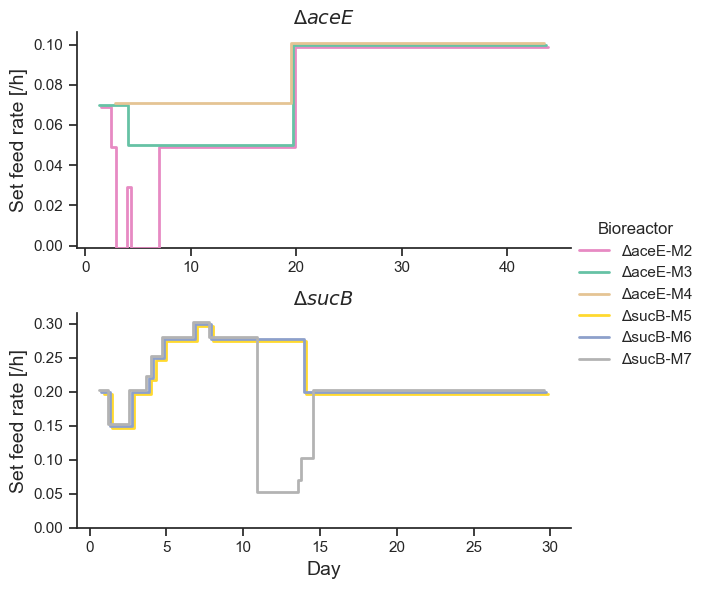

In [174]:

g = sns.relplot(data=df_feed_ratesL, x='Day (for vis)', y='Feed rate [/h] (for visualization)', hue = 'Bioreactor', kind='line',
            aspect=2, marker = None, row = 'Strain', height=3, estimator=None, lw = 2,
            facet_kws={'sharex':False, 'sharey':False,}, palette=strains_cmap, drawstyle =  'steps-post', zorder = 100)
g.set_titles(r"Δ${row_name}$", size = 14)  # Sets titles to only display the strain name
g.set_ylabels('Set feed rate [/h]', size = 14)
g.set_xlabels('Day', size = 14)
for ax in g.axes.flat:
    ax.set_ylim(-0.001)
plt.savefig(figure_folder / 'chemostat_set_feed_rate.pdf', bbox_inches='tight')

# Plot OD curves of selected colonies of aceE and sucB

In [5]:
df_tubes = pd.read_csv(fn_tubes)
df_samples = pd.read_csv(fn_tube_samples)

In [6]:
df_tubes.rename(columns={'Hours': 'Time [h]'}, inplace=True)
df_samples.rename(columns={'Hours': 'Time [h]'}, inplace=True)

In [7]:
df_samples['Strain abbrv.'].unique()

array(['WT', 'aceE', 'aceE-M2', 'aceE-M3', 'aceE-M4', 'sucB', 'sucB-M5',
       'sucB-M6', 'sucB-M7'], dtype=object)

In [8]:
set2

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

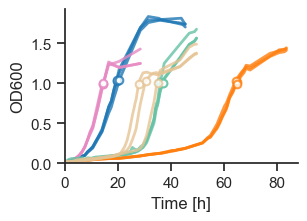

In [9]:
aceE_abbrv = ['WT', 'aceE', 'aceE-M2', 'aceE-M3', 'aceE-M4']

df_tubes['Label'] = df_tubes['Strain abbrv.'].map(label_mapping)
aceE_idx = df_tubes['Strain abbrv.'].isin(aceE_abbrv)
fig, ax  = plt.subplots(figsize=(3, 2))
ax = sns.lineplot(data = df_tubes.loc[aceE_idx], x = 'Time [h]', y = 'OD600', hue = 'Label', estimator=None,
                   units='Replicate', palette=strains_cmap, lw = 2, ax = ax, alpha = 0.8, legend=False)
for strain in aceE_abbrv:
    sidx = df_samples['Strain abbrv.']==strain
    label = label_mapping[strain]
    ax.scatter(x = df_samples.loc[sidx, 'Sampling time'], y = df_samples.loc[sidx, 'Sample OD'], c = 'w', 
               s = 30, label = label, edgecolor =strains_cmap[label], alpha = 0.8, zorder = 10, linewidths=1.5)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title = 'Strain', fontsize = 10, ncol = 1,)
ax.set_xlim(0)
ax.set_ylim(0)
sns.despine()
plt.savefig(figure_folder / 'aceE_sampling.pdf', bbox_inches='tight')

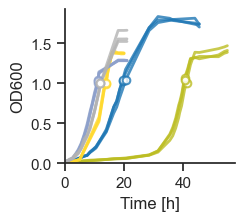

In [10]:
sucB_abbrv = ['WT', 'sucB', 'sucB-M5', 'sucB-M6', 'sucB-M7']

df_tubes['Label'] = df_tubes['Strain abbrv.'].map(label_mapping)
sucB_idx = df_tubes['Strain abbrv.'].isin(sucB_abbrv)
fig, ax  = plt.subplots(figsize=(2.2, 2))
ax = sns.lineplot(data = df_tubes.loc[sucB_idx], x = 'Time [h]', y = 'OD600', hue = 'Label', estimator=None,
                   units='Replicate', palette=strains_cmap, lw = 2, ax = ax, alpha = 0.8,
                   hue_order=[label_mapping[x] for x in sucB_abbrv], legend=False)
for strain in sucB_abbrv:
    sidx = df_samples['Strain abbrv.']==strain
    label = label_mapping[strain]
    ax.scatter(x = df_samples.loc[sidx, 'Sampling time'], y = df_samples.loc[sidx, 'Sample OD'], c = 'w', 
               s = 30, label = label, edgecolor =strains_cmap[label], alpha = 0.8, zorder = 10, linewidths=1.5)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title = 'Strain', fontsize = 10, ncol = 1,)
ax.set_xlim(0)
ax.set_ylim(0)
sns.despine()
plt.savefig(figure_folder / 'sucB_sampling.pdf', bbox_inches='tight')

## Estimate growth rate

In [11]:
df_tubes

,Strain abbrv.,Replicate,Strain,Time [h],OD600,Label
0,WT,A,E. coli BW25113,0.0,0.016,E. coli WT
1,WT,B,E. coli BW25113,0.0,0.016,E. coli WT
2,WT,C,E. coli BW25113,0.0,0.019,E. coli WT
3,aceE,A,aceE-Ancestor,0.0,0.018,ΔaceE
4,aceE,B,aceE-Ancestor,0.0,0.020,ΔaceE
...,...,...,...,...,...,...
1261,sucB-M5,B,sucB-M5-D30-4,19.0,1.383,ΔsucB-M5
1262,sucB-M5,C,sucB-M5-D30-4,19.0,1.368,ΔsucB-M5
1263,sucB-M5,A,sucB-M5-D30-4,20.0,1.379,ΔsucB-M5
1264,sucB-M5,B,sucB-M5-D30-4,20.0,1.379,ΔsucB-M5


In [12]:
label_to_abbrv = {val:key for key, val in label_mapping.items()}

E. coli WT A Axes(0.0640046,0.894338;0.290188x0.0914354)
[ 3.66666667 19.5       ] [-2.9786971   0.15773055]
E. coli WT B Axes(0.378575,0.894338;0.290188x0.0914354)
[ 3.66666667 19.5       ] [-2.96110827  0.16702961]
E. coli WT C Axes(0.693146,0.894338;0.290188x0.0914354)
[ 3.66666667 20.5       ] [-2.96335619  0.18476448]
ΔaceE A Axes(0.0640046,0.78559;0.290188x0.0914354)
[52.         66.66666667] [-1.37310547  0.22426265]
ΔaceE B Axes(0.378575,0.78559;0.290188x0.0914354)
[52.         66.66666667] [-1.30667387  0.28586069]
ΔaceE C Axes(0.693146,0.78559;0.290188x0.0914354)
[52.         66.66666667] [-1.38703956  0.20574558]
ΔaceE-M2 A Axes(0.0640046,0.676842;0.290188x0.0914354)
[ 3.66666667 14.5       ] [-2.72373575  0.21944457]
ΔaceE-M2 B Axes(0.378575,0.676842;0.290188x0.0914354)
[ 3.66666667 14.5       ] [-2.68544365  0.16202796]
ΔaceE-M2 C Axes(0.693146,0.676842;0.290188x0.0914354)
[ 3.66666667 14.5       ] [-2.73139082  0.17416231]
ΔsucB A Axes(0.0640046,0.568093;0.290188x0.091435

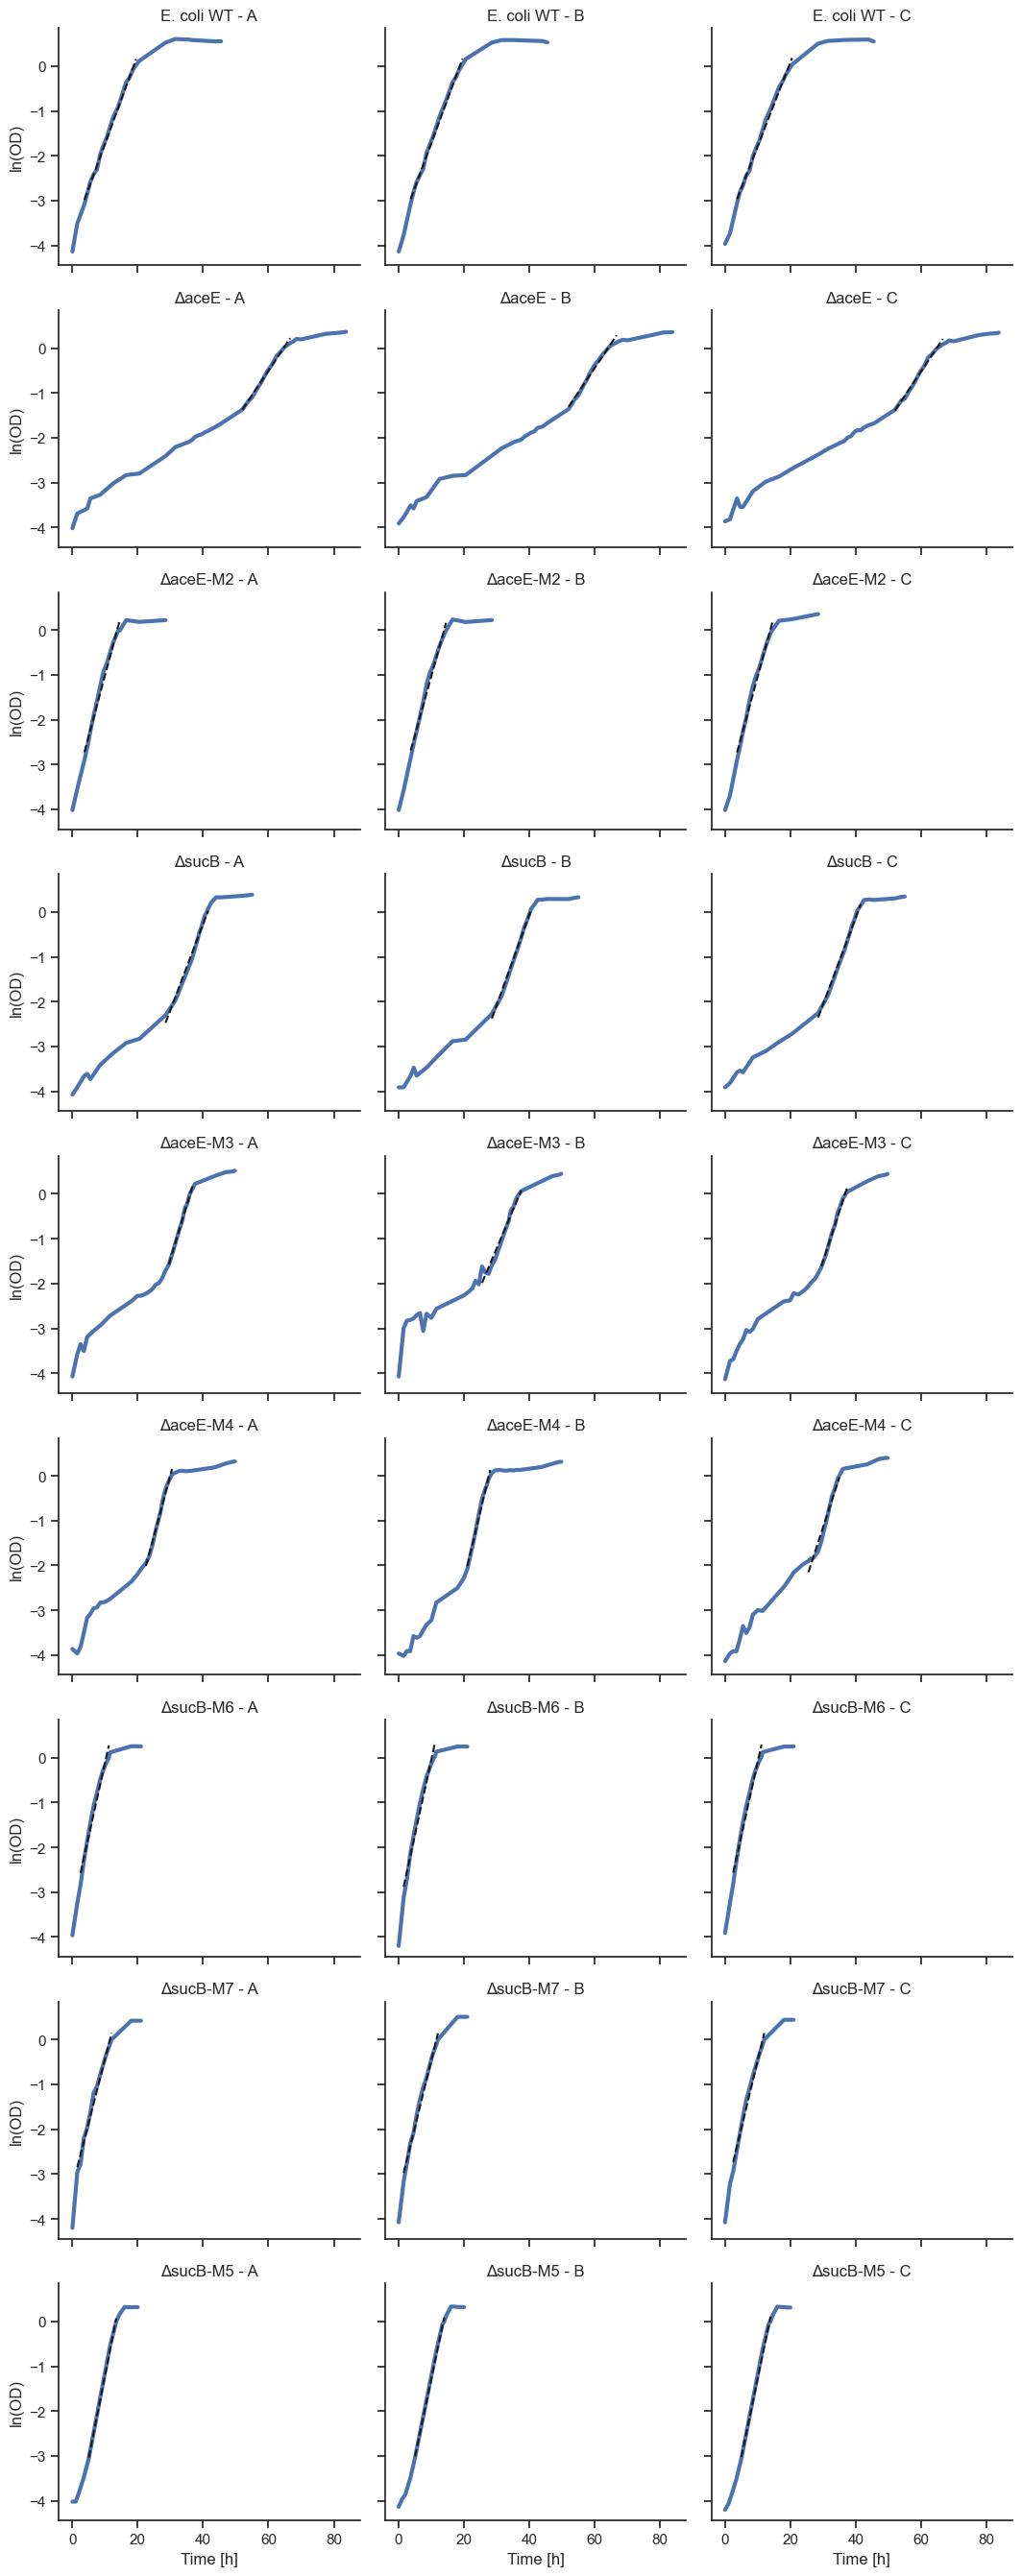

In [13]:
all_strains = set(aceE_abbrv + sucB_abbrv)
df_tubes['ln(OD)'] = np.log([x for x in df_tubes['OD600']])
g = sns.relplot(data=df_tubes, x = 'Time [h]', y = 'ln(OD)', row = 'Label', col = 'Replicate', kind = 'line', lw = 3, height = 3, aspect = 1.2)

g.set_titles("{row_name} - {col_name}", size = 12)  # Sets titles to only display the strain name

data = []
default_od_range = [0.05, 1]
for label in df_tubes['Label'].unique():
    for j, rep in enumerate('ABC'):
        idx = (df_tubes['Label']==label) & (df_tubes['Replicate']==rep)
        dfi = df_tubes.loc[idx]
        ax = g.axes_dict[(label, rep)]
        if label == 'ΔaceE':
            od_range = [0.25,1.1]
        elif label == 'ΔsucB':
            od_range = [0.1, 1.1]
        elif label == 'ΔaceE-M3':
            od_range = [0.2, 1.1]
        elif label == 'ΔaceE-M4':
            od_range = [0.15, 1]
        else:
            od_range = default_od_range
        print(label, rep, ax)
        idx0 = (dfi['OD600']-od_range[0]).abs().argmin()
        idx1 = (dfi['OD600']-od_range[1]).abs().argmin()
        
        ln_OD = dfi.iloc[idx0:idx1+1]['ln(OD)']
        hours = dfi.iloc[idx0:idx1+1]['Time [h]']
        
        hours = hours.loc[ln_OD.notna()]
        ln_OD = ln_OD.loc[ln_OD.notna()]
        fit = np.polyfit(hours, ln_OD, 1)
        x_arr = np.linspace(hours.min(), hours.max(), 2)
        y_arr = x_arr*fit[0]+fit[1]
        print(x_arr, y_arr)
        # delta_ln_OD = - dfi.iloc[idx0]['ln(OD)']
        # delta_t = dfi.Hours.iloc[idx1]-dfi.Hours.iloc[idx0]
        # growth_rate = delta_ln_OD/delta_t
        growth_rate = fit[0]
        abbrv = label_to_abbrv[label]
        data.append([abbrv, label, rep, growth_rate])

        # Plot
        # ax.plot([dfi.Hours.iloc[idx0], dfi.Hours.iloc[idx1]], [dfi.iloc[idx0]['ln(OD)'], dfi.iloc[idx1]['ln(OD)']], c = 'k', ls = '--')
        ax.plot(x_arr, y_arr, c = 'k', ls = '--')

    

In [14]:
rate_data = pd.DataFrame(data, columns = ['Strain abbrv.', 'Label', 'Replicate', 'Growth rate'])

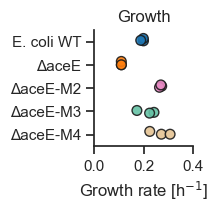

In [15]:
# fig, ax = plt.subplots(1,figsize=(2, 2)) 
add_stats = False
idx = rate_data['Strain abbrv.'].isin(aceE_abbrv)
# g = sns.catplot(data = rate_data.loc[idx], y = 'Label', x = 'Growth rate', color = 'w', #ax = ax,
#             order = [label_mapping[x] for x in aceE_abbrv], kind = 'box', height = 2, aspect = 1.2)
g = sns.FacetGrid(data = rate_data.loc[idx],height = 2, aspect = 1.2)
g.map_dataframe(sns.stripplot, y = 'Label', x = 'Growth rate', hue = 'Label', 
              palette = strains_cmap, ax = ax, alpha = 0.9, size = 7, edgecolor='k', linewidth = 1,
              jitter=0.2)

if add_stats:
    # Define pairs of groups to compare
    pairs = [
        ("ΔaceE", "ΔaceE-M2"),
        ("ΔaceE", "ΔaceE-M3"),
        ("ΔaceE", "ΔaceE-M4"),
    ]

    # Add statistical annotations
    for ax, metabolite in zip(g.axes.flat, ['Growth']):
        # ax.set_xlim(0.1, 0.6)
        data = rate_data.loc[idx]
        annotator = Annotator(ax, pairs, data=data, y="Label", x="Growth rate",
                            orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
        annotator.configure(test="t-test_welch", text_format="star", loc="inside",# verbose=1,
                            # line_offset=20,
                            # text_offset=0,
                            # line_offset_to_box=10,
                            )

                            # text_offset=1, line_height=0.02)
        # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
        annotator.apply_and_annotate()

sns.despine()
g.set_axis_labels('Growth rate [h$^{-1}$]', '')
for ax in g.axes.flat:
    ax.set_title('Growth', size = 12)
    ax.set_xlim(0.0, 0.4)
plt.savefig(figure_folder / 'aceE_growth_rate.pdf', bbox_inches='tight')

In [16]:
mean_mu = rate_data.groupby('Strain abbrv.').agg({'Growth rate':'mean'}).to_dict()['Growth rate']
std_mu = rate_data.groupby('Strain abbrv.').agg({'Growth rate':'std'}).to_dict()['Growth rate']

In [18]:
mean_mu

{'WT': 0.1942246133168077,
 'aceE': 0.10869745040415339,
 'aceE-M2': 0.2675755400536303,
 'aceE-M3': 0.21166934656688316,
 'aceE-M4': 0.2665190003483305,
 'sucB': 0.19594276137171798,
 'sucB-M5': 0.35601225537019143,
 'sucB-M6': 0.33093894838575966,
 'sucB-M7': 0.29476946034964285}

In [17]:
percentage_increase_aceE = []
percentage_increase_sucB = []
increase_sucB = []
increase_aceE = []
aceE_val = uncertainties.ufloat(mean_mu['aceE'], std_mu['aceE'])
sucB_val = uncertainties.ufloat(mean_mu['sucB'], std_mu['sucB'])
for strain in aceE_abbrv:
    print(f'{strain}/aceE', mean_mu[strain]/mean_mu['aceE'])
    print(f'{strain}/WT', mean_mu[strain]/mean_mu['WT']),
    if strain in ['WT', 'aceE']:
        continue
    ko_val = uncertainties.ufloat(mean_mu[strain], std_mu[strain])
    pi  = (ko_val - aceE_val)/aceE_val*100
    increase = (ko_val - aceE_val)
    increase_aceE.append(increase)
    percentage_increase_aceE.append(pi)
for strain in sucB_abbrv:
    print(f'{strain}/sucB', mean_mu[strain]/mean_mu['sucB'])
    print(f'{strain}/WT', mean_mu[strain]/mean_mu['WT']),
    if strain in ['sucB', 'WT']:
        continue
    ko_val = uncertainties.ufloat(mean_mu[strain], std_mu[strain])
    pi  = (ko_val - sucB_val)/sucB_val*100
    increase = (ko_val - sucB_val)
    percentage_increase_sucB.append(pi)
    increase_sucB.append(increase)



WT/aceE 1.7868368815887725
WT/WT 1.0
aceE/aceE 1.0
aceE/WT 0.5596481751097763
aceE-M2/aceE 2.4616542435792597
aceE-M2/WT 1.3776603051703695
aceE-M3/aceE 1.947325772406481
aceE-M3/WT 1.0898173148715227
aceE-M4/aceE 2.4519342390955163
aceE-M4/WT 1.3722205223989836
WT/sucB 0.9912313777611268
WT/WT 1.0
sucB/sucB 1.0
sucB/WT 1.0088461911472968
sucB-M5/sucB 1.8169196599960624
sucB-M5/WT 1.832992478607669
sucB-M6/sucB 1.6889572550115484
sucB-M6/WT 1.703898093728994
sucB-M7/sucB 1.5043651436066234
sucB-M7/WT 1.517673045222298


In [46]:
[x/0.405 for x in increase_sucB]

[0.39523331851474924+/-0.031083894447250508,
 0.3333239185531893+/-0.015410236865403795,
 0.24401654068623424+/-0.026034294747217145]

In [47]:
print('aceE',percentage_increase_aceE)
print('sucB',percentage_increase_sucB)


aceE [146.16542435792596+/-4.116192308988571, 94.7325772406481+/-32.930242886505006, 145.19342390955163+/-37.93249749373077]
sucB [81.69196599960624+/-7.5852859222257125, 68.89572550115484+/-4.82017372146574, 50.43651436066233+/-6.15470135510147]


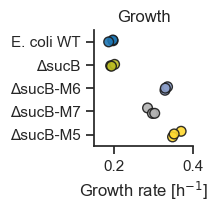

In [48]:
# fig, ax = plt.subplots(1,figsize=(2, 2))
add_stats = False
idx = rate_data['Strain abbrv.'].isin(sucB_abbrv)
g = sns.FacetGrid(data = rate_data.loc[idx], height = 2, aspect = 1.2)
# g = sns.catplot(data = rate_data.loc[idx], y = 'Label', x = 'Growth rate', color = 'w', #ax = ax,
#             order = [label_mapping[x] for x in sucB_abbrv], kind = 'box', height = 2, aspect = 1.2)
g.map_dataframe(sns.stripplot, y = 'Label', x = 'Growth rate', hue = 'Label', 
              palette = strains_cmap, ax = ax, alpha = 0.9, size = 7, edgecolor='k', linewidth = 1,
              jitter=0.2)

if add_stats:
    # Define pairs of groups to compare
    pairs = [
        ("ΔsucB", "ΔsucB-M5"),
        ("ΔsucB", "ΔsucB-M6"),
        ("ΔsucB", "ΔsucB-M7"),
    ]

    # Add statistical annotations
    for ax, metabolite in zip(g.axes.flat, ['Growth']):
        # ax.set_xlim(0.1, 0.6)
        data = rate_data.loc[idx]
        annotator = Annotator(ax, pairs, data=data, y="Label", x="Growth rate",
                            orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
        annotator.configure(test="t-test_welch", text_format="star", loc="inside",# verbose=1,
                            # line_offset=20,
                            # text_offset=0,
                            # line_offset_to_box=10,
                            )

                            # text_offset=1, line_height=0.02)
        # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
        annotator.apply_and_annotate()



sns.despine()
g.set_axis_labels('Growth rate [h$^{-1}$]', '')
for ax in g.axes.flat:
    ax.set_title('Growth', size = 12)
    ax.set_xlim(0.15, 0.4)
plt.savefig(figure_folder / 'sucB_growth_rate.pdf', bbox_inches='tight')


# Plot metabolomics

In [49]:
df_nM = pd.read_csv(fn_exometabolome_nM)
# df_nM.replace({'Concentration [nM]': {'ND':np.nan}}, inplace=True)
# df_nM['Concentration [nM]'] = df_nM['Concentration [nM]'].astype(float)

df_counts = pd.read_csv(fn_exometabolome_counts)

In [50]:
df_nM.loc[df_nM.Metabolite=='Glutamine']

,Strain,Replicate,Metabolite,Concentration [nM],Label,Concentration [nΜ],Concentration [μΜ],AUC [gDW/L*h],Rate [mmol/gDW/h]
30,sucB-M5,A,Glutamine,NaN,ΔsucB-M5,NaN,NaN,1.271767,NaN
31,sucB-M5,B,Glutamine,14.465012,ΔsucB-M5,NaN,0.014465,1.340797,0.000011
32,sucB-M5,C,Glutamine,14.902798,ΔsucB-M5,NaN,0.014903,1.373058,0.000011
33,sucB-M6,A,Glutamine,17.928747,ΔsucB-M6,NaN,0.017929,1.345366,0.000013
34,sucB-M6,B,Glutamine,18.524878,ΔsucB-M6,NaN,0.018525,1.428306,0.000013
35,sucB-M6,C,Glutamine,15.755437,ΔsucB-M6,NaN,0.015755,1.364427,0.000012
36,sucB-M7,A,Glutamine,13.371889,ΔsucB-M7,NaN,0.013372,1.369641,0.000010
37,sucB-M7,B,Glutamine,17.655414,ΔsucB-M7,NaN,0.017655,1.315838,0.000013
38,sucB-M7,C,Glutamine,13.247255,ΔsucB-M7,NaN,0.013247,1.300182,0.000010
39,sucB,A,Glutamine,16.183914,ΔsucB,NaN,0.016184,2.059250,0.000008


In [51]:
# df_nM['Label'] = df_nM['Strain'].map(label_mapping)
df_counts['Label'] = df_counts['Strain'].map(label_mapping)

In [52]:
# Calculate rates for count df as well
strain_rep_to_auc = df_nM.groupby(['Strain', 'Replicate'])['AUC [gDW/L*h]'].first().to_dict()
df_counts['AUC [gDW/L*h]'] = df_counts.apply(
    lambda row: strain_rep_to_auc.get((row['Strain'], row['Replicate']), np.nan), axis=1)
df_counts['Rate [A.U.]'] = df_counts['Counts'] / df_counts['AUC [gDW/L*h]']

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:2.237e-06 t=4.275e+01
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:4.986e-02 t=-4.238e+00
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:6.815e-07 t=5.478e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:5.033e-02 t=-2.930e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:5.792e-04 t=-4.153e+01
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:1.277e-02 t=-8.766e+00


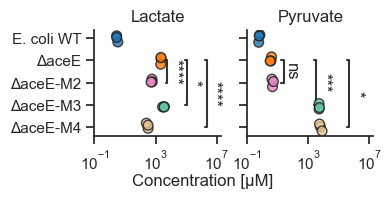

In [102]:
aceE_mets = ['Lactate', 'Pyruvate', 'Valine','Fructose-6-phosphate']
aceE_mets_main = ['Lactate', 'Pyruvate']
idx = (df_nM['Strain'].isin(aceE_abbrv))&(df_nM['Metabolite'].isin(aceE_mets_main))

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Concentration [μΜ]', 
            hue = 'Label', 
            col = 'Metabolite', #kind = 'box',
            palette = strains_cmap, 
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            # color = 'w',
            jitter=0.2, 
            height = 2.1, aspect = 1, col_wrap=2, sharex=True,
            col_order=aceE_mets_main, order = [label_mapping[x] for x in aceE_abbrv])
# g = sns.FacetGrid(data=df_nM.loc[idx], col='Metabolite', height=2.1, aspect=1, col_wrap=2, sharex=True,
#                   col_order=aceE_mets_main)
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Concentration [μΜ]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2, order = [label_mapping[x] for x in aceE_abbrv])

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    
    ax.set_xlabel('')
    ax.set_xlim(0.1, 1e4)
g.figure.supxlabel('Concentration [μΜ]', fontsize=12, y = 0.06, x = 0.55)

# Define pairs of groups to compare
pairs = [
    ("ΔaceE", "ΔaceE-M2"),
    ("ΔaceE", "ΔaceE-M3"),
    ("ΔaceE", "ΔaceE-M4"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, aceE_mets_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Concentration [μΜ]",
                           orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'aceE_main_exometabolome.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'aceE_main_exometabolome.png', bbox_inches='tight', dpi=300)

In [104]:
df_nM.loc[idx].groupby(['Strain', 'Metabolite'])['Concentration [μΜ]'].mean().to_dict()

{('WT', 'Lactate'): 3.0328237790055166,
 ('WT', 'Pyruvate'): 0.6268964230875427,
 ('aceE', 'Lactate'): 2261.2658476044303,
 ('aceE', 'Pyruvate'): 3.6029381243713665,
 ('aceE-M2', 'Lactate'): 568.768866375084,
 ('aceE-M2', 'Pyruvate'): 4.712165640247133,
 ('aceE-M3', 'Lactate'): 3435.560807925883,
 ('aceE-M3', 'Pyruvate'): 5261.404358605893,
 ('aceE-M4', 'Lactate'): 301.333170643453,
 ('aceE-M4', 'Pyruvate'): 6680.3974944757065}

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:7.090e-03 t=8.056e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:2.370e-03 t=-1.900e+01
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:2.305e-05 t=4.593e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:7.797e-03 t=-9.663e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:4.342e-03 t=-1.513e+01
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:4.091e-03 t=-1.559e+01


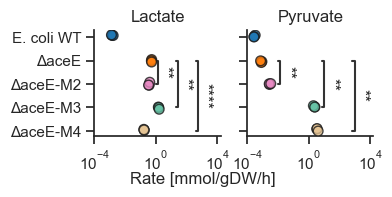

In [83]:
aceE_mets = ['Lactate', 'Pyruvate', 'Valine','Fructose-6-phosphate']
aceE_mets_main = ['Lactate', 'Pyruvate']
idx = (df_nM['Strain'].isin(aceE_abbrv))&(df_nM['Metabolite'].isin(aceE_mets_main))

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Rate [mmol/gDW/h]', 
            hue = 'Label', 
            col = 'Metabolite', #kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            height = 2.1, aspect = 1, col_wrap=2, sharex=True,
            col_order=aceE_mets_main, order = [label_mapping[x] for x in aceE_abbrv])
# g = sns.FacetGrid(data=df_nM.loc[idx], col='Metabolite', height=2.1, aspect=1, col_wrap=2, sharex=True,
#                   col_order=aceE_mets_main)
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Rate [mmol/gDW/h]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2, order = [label_mapping[x] for x in aceE_abbrv])

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    
    ax.set_xlabel('')
    ax.set_xlim(1e-4, 1e1)
g.figure.supxlabel('Rate [mmol/gDW/h]', fontsize=12, y = 0.07, x = 0.55)

# Define pairs of groups to compare
pairs = [
    ("ΔaceE", "ΔaceE-M2"),
    ("ΔaceE", "ΔaceE-M3"),
    ("ΔaceE", "ΔaceE-M4"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, aceE_mets_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Rate [mmol/gDW/h]",
                           orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'aceE_main_exometabolome_rate.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'aceE_main_exometabolome_rate.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:6.994e-03 t=-7.748e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:1.785e-01 t=-2.037e+00
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:2.562e-03 t=-1.746e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:4.043e-01 t=-1.028e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:4.290e-02 t=-3.331e+00
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:8.027e-01 t=-2.791e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **:

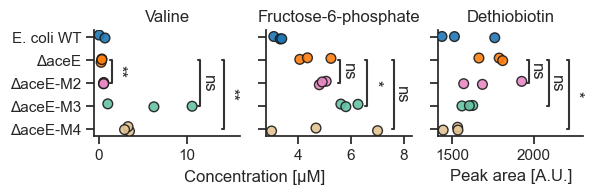

In [84]:
aceE_mets_not_main = ['Valine','Fructose-6-phosphate', 'Dethiobiotin']
idx = (df_nM['Strain'].isin(aceE_abbrv))&(df_nM['Metabolite'].isin(aceE_mets_not_main))&(df_nM['Concentration [nM]']>0)

# SMall hack to get it into the same plot
df_nMXX = pd.concat([df_nM.loc[idx], df_counts.loc[(df_counts['Metabolite'] == 'Dethiobiotin')&(df_counts['Strain'].isin(aceE_abbrv))]])
df_nMXX.loc[df_nMXX['Metabolite'] == 'Dethiobiotin', 'Rate [mmol/gDW/h]'] = df_nMXX.loc[df_nMXX['Metabolite'] == 'Dethiobiotin', 'Rate [A.U.]'] 
df_nMXX.loc[df_nMXX['Metabolite'] == 'Dethiobiotin', 'Concentration [μΜ]'] = df_nMXX.loc[df_nMXX['Metabolite'] == 'Dethiobiotin', 'Counts']

g = sns.catplot(data = df_nMXX, y = 'Label', x = 'Concentration [μΜ]', 
            hue = 'Label', 
            col = 'Metabolite', #kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            size = 7,
            alpha = 0.9, edgecolor='k', linewidth = 1,
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            col_order=aceE_mets_not_main, order = [label_mapping[x] for x in aceE_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Concentration [μΜ]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for i, ax in enumerate(g.axes.flat):
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    
    if i <2:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Peak area [A.U.]', fontsize=12)
# g.axes.flat[0].set_xlim(1e-3, )
# g.axes.flat[1].set_xlim(1e0, 1e1)
g.figure.supxlabel('Concentration [μΜ]', fontsize=12, x=0.45, y = 0.08)

# Define pairs of groups to compare
pairs = [
    ("ΔaceE", "ΔaceE-M2"),
    ("ΔaceE", "ΔaceE-M3"),
    ("ΔaceE", "ΔaceE-M4"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, aceE_mets_not_main):
    data = df_nMXX.loc[(df_nMXX["Metabolite"] == metabolite)]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Concentration [μΜ]",
                           orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'aceE_not_main_exometabolome.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'aceE_not_main_exometabolome.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:6.951e-06 t=-3.149e+01
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:1.540e-01 t=-2.243e+00
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:1.054e-02 t=-9.627e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:6.314e-04 t=-2.423e+01
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:3.098e-03 t=-8.862e+00
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:1.027e-01 t=-2.806e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **:

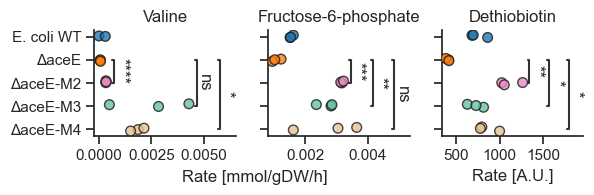

In [86]:
aceE_mets_not_main = ['Valine','Fructose-6-phosphate', 'Dethiobiotin']

idx = (df_nM['Strain'].isin(aceE_abbrv))&(df_nM['Metabolite'].isin(aceE_mets_not_main))&(df_nM['Concentration [nM]']>0)


g = sns.catplot(data = df_nMXX, y = 'Label', x = 'Rate [mmol/gDW/h]', 
            hue = 'Label', 
            col = 'Metabolite',# kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            col_order=aceE_mets_not_main, order = [label_mapping[x] for x in aceE_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Rate [mmol/gDW/h]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for j, ax in enumerate(g.axes.flat):
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    # if j == 0:
    #     ax.set_xlim(1e-6, 1e2)
    # else:
    #     ax.set_xlim(1e-4, 1e1)
    if j <2:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Rate [A.U.]', fontsize=12)

    
g.figure.supxlabel('Rate [mmol/gDW/h]', fontsize=12, x =0.45, y = 0.08)

# Define pairs of groups to compare
pairs = [
    ("ΔaceE", "ΔaceE-M2"),
    ("ΔaceE", "ΔaceE-M3"),
    ("ΔaceE", "ΔaceE-M4"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, aceE_mets_not_main):
    data = df_nMXX.loc[(df_nMXX["Metabolite"] == metabolite)]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Rate [mmol/gDW/h]",
                           orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'aceE_not_main_exometabolome_rate.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'aceE_not_main_exometabolome_rate.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:2.123e-04 t=2.960e+01
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:3.566e-02 t=-4.871e+00
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:6.218e-05 t=4.124e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:8.837e-03 t=-4.785e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:7.230e-04 t=-3.717e+01
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:2.444e-03 t=-2.019e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1

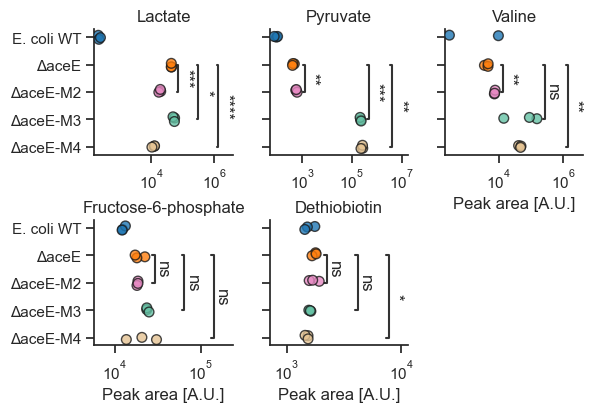

In [90]:
aceE_mets = ['Lactate', 'Pyruvate', 'Valine','Fructose-6-phosphate', 'Dethiobiotin']
# aceE_mets_not_main = ['Valine','Fructose-6-phosphate']
idx = (df_counts['Strain'].isin(aceE_abbrv))&(df_counts['Metabolite'].isin(aceE_mets))&(df_counts['Counts']>0)

g = sns.catplot(data = df_counts.loc[idx], y = 'Label', x = 'Counts', 
            hue = 'Label', 
            col = 'Metabolite',# kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            col_order=aceE_mets, order = [label_mapping[x] for x in aceE_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Counts', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)
g.set_axis_labels('Peak area [A.U.]', '')
# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    if ax.get_xbound()[1]/ax.get_xbound()[0] < 10:
        ax.set_xlim(ax.get_xbound()[0]*0.5, ax.get_xbound()[1]*5) 
        # ax.set_xlabel('')
    # ax.set_xlim(0.1, )
# g.figure.supxlabel('Concentration [μΜ]', fontsize=12)
# g.axes.flat[-1].set_xlim(1e3, 5e3)
# Define pairs of groups to compare
pairs = [
    ("ΔaceE", "ΔaceE-M2"),
    ("ΔaceE", "ΔaceE-M3"),
    ("ΔaceE", "ΔaceE-M4"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, aceE_mets):
    data = df_counts.loc[(df_counts["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Counts",
                           orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'aceE_counts_exometabolome.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'aceE_counts_exometabolome.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:9.313e-02 t=2.454e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:2.131e-01 t=1.484e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:4.489e-02 t=3.632e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:2.124e-03 t=7.397e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:8.799e-01 t=1.649e-01
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:5.896e-02 t=3.201e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e

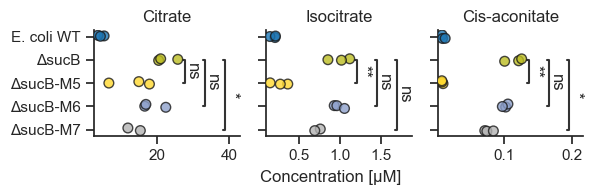

In [91]:
sucB_mets = ['Citrate', 'Isocitrate', 'Cis-aconitate','Adenosine', 'Glutamine']
sucB_mets_main = ['Citrate', 'Isocitrate', 'Cis-aconitate']
idx = (df_nM['Strain'].isin(sucB_abbrv))&(df_nM['Metabolite'].isin(sucB_mets_main))

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Concentration [μΜ]', 
            hue = 'Label', 
            col = 'Metabolite', #kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            col_order=sucB_mets_main, order = [label_mapping[x] for x in sucB_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Concentration [μΜ]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    ax.set_xlabel('')
g.figure.supxlabel('Concentration [μΜ]', fontsize=12, y = 0.08, x = 0.57)
    
# Define pairs of groups to compare
pairs = [
    ("ΔsucB", "ΔsucB-M5"),
    ("ΔsucB", "ΔsucB-M6"),
    ("ΔsucB", "ΔsucB-M7"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, sucB_mets_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Concentration [μΜ]",
                           orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'sucB_main_exometabolome.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'sucB_main_exometabolome.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:7.709e-01 t=3.255e-01
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:1.768e-01 t=-1.751e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:7.591e-01 t=3.483e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:9.170e-03 t=5.075e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:5.750e-03 t=-5.392e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:1.508e-01 t=-2.073e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.

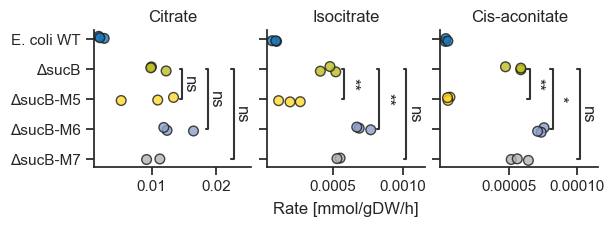

In [92]:

idx = (df_nM['Strain'].isin(sucB_abbrv))&(df_nM['Metabolite'].isin(sucB_mets_main))

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Rate [mmol/gDW/h]', 
            hue = 'Label', 
            col = 'Metabolite',# kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            col_order=sucB_mets_main, order = [label_mapping[x] for x in sucB_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Rate [mmol/gDW/h]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    # ax.set_xscale('log')  # Set log scale
    # ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    ax.set_xlabel('')
g.figure.supxlabel('Rate [mmol/gDW/h]', fontsize=12)
    
# Define pairs of groups to compare
pairs = [
    ("ΔsucB", "ΔsucB-M5"),
    ("ΔsucB", "ΔsucB-M6"),
    ("ΔsucB", "ΔsucB-M7"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, sucB_mets_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Rate [mmol/gDW/h]",
                           orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()

# from matplotlib.ticker import FuncFormatter
# for ax in g.axes.flat:
#     ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0e}'))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25, wspace=0.1)
# plt.show()
plt.savefig(figure_folder / 'sucB_main_exometabolome_rate.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'sucB_main_exometabolome_rate.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:8.955e-01 t=1.472e-01
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:1.698e-01 t=-1.722e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:1.715e-01 t=1.664e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:2.513e-02 t=4.269e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:4.313e-01 t=-9.175e-01
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:3.402e-01 t=1.200e+00


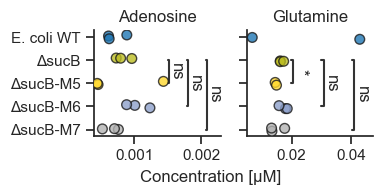

In [93]:
sucB_mets = ['Citrate', 'Isocitrate', 'Cis-aconitate','Adenosine', 'Glutamine']
sucB_mets_main = ['Citrate', 'Isocitrate', 'Cis-aconitate']
sucB_mets_not_main = ['Adenosine', 'Glutamine']
idx = (df_nM['Strain'].isin(sucB_abbrv))&(df_nM['Metabolite'].isin(sucB_mets_not_main))&(df_nM['Concentration [nM]']>0)

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Concentration [μΜ]', 
            hue = 'Label', 
            col = 'Metabolite',# kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            height = 2.1, aspect = 1, col_wrap=2, sharex=False,
            col_order=sucB_mets_not_main, order = [label_mapping[x] for x in sucB_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Concentration [μΜ]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    ax.set_xlabel('')
g.figure.supxlabel('Concentration [μΜ]', fontsize=12, y = 0.08, x = 0.57)
    
# Define pairs of groups to compare
pairs = [
    ("ΔsucB", "ΔsucB-M5"),
    ("ΔsucB", "ΔsucB-M6"),
    ("ΔsucB", "ΔsucB-M7"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, sucB_mets_not_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Concentration [μΜ]",
                           orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()

    
# plt.show()
plt.savefig(figure_folder / 'sucB_not_main_exometabolome.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'sucB_not_main_exometabolome.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:5.182e-01 t=-7.740e-01
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:1.532e-02 t=-5.271e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:1.602e-01 t=-1.823e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:3.159e-03 t=-1.562e+01
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:7.518e-03 t=-8.245e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:1.032e-01 t=-2.775e+00


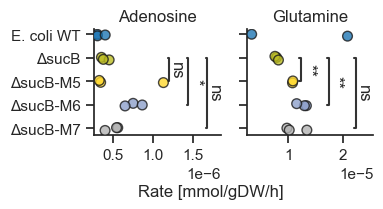

In [95]:

idx = (df_nM['Strain'].isin(sucB_abbrv))&(df_nM['Metabolite'].isin(sucB_mets_not_main))&(df_nM['Concentration [nM]']>0)

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Rate [mmol/gDW/h]', 
            hue = 'Label', 
            col = 'Metabolite',# kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            height = 2.1, aspect = 1, col_wrap=2, sharex=False,
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            col_order=sucB_mets_not_main, order = [label_mapping[x] for x in sucB_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Rate [mmol/gDW/h]', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    ax.set_xlabel('')
    # ax.set_xlim(1e-7)
g.figure.supxlabel('Rate [mmol/gDW/h]', fontsize=12, y = 0.01, x = 0.57)
    
# Define pairs of groups to compare
pairs = [
    ("ΔsucB", "ΔsucB-M5"),
    ("ΔsucB", "ΔsucB-M6"),
    ("ΔsucB", "ΔsucB-M7"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, sucB_mets_not_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Rate [mmol/gDW/h]",
                           orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()

    
# plt.show()
plt.savefig(figure_folder / 'sucB_not_main_exometabolome_rate.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'sucB_not_main_exometabolome_rate.png', bbox_inches='tight', dpi=300)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:1.072e-01 t=2.479e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:1.662e-01 t=1.725e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:9.466e-01 t=-7.527e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:1.130e-03 t=8.342e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:8.841e-01 t=-1.598e-01
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:5.733e-01 t=6.361e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.0

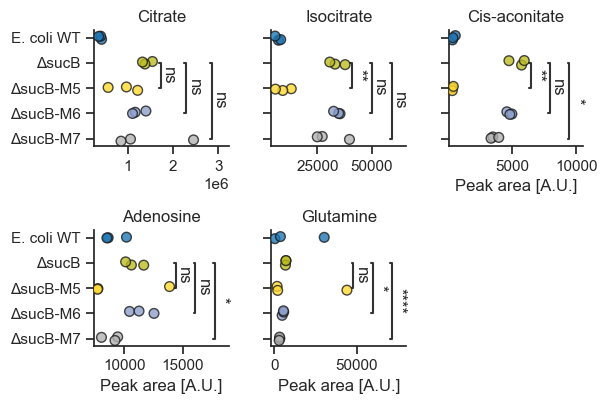

In [97]:
sucB_mets = ['Citrate', 'Isocitrate', 'Cis-aconitate','Adenosine', 'Glutamine']
sucB_mets_main = ['Citrate', 'Isocitrate', 'Cis-aconitate']
sucB_mets_not_main = ['Adenosine', 'Glutamine']
idx = (df_counts['Strain'].isin(sucB_abbrv))&(df_counts['Metabolite'].isin(sucB_mets))&(df_counts['Counts']>0)

g = sns.catplot(data = df_counts.loc[idx], y = 'Label', x = 'Counts', 
            hue = 'Label', 
            col = 'Metabolite',# kind = 'box',
            palette = strains_cmap, 
            # color = 'w',
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
            col_order=sucB_mets, order = [label_mapping[x] for x in sucB_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
# g.map_dataframe(sns.stripplot, x = 'Counts', y = 'Label',
#                 hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
#                 jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    # ax.set_xlabel('')
g.set_axis_labels('Peak area [A.U.]', '')

# g.figure.supxlabel('Counts', fontsize=12)
    
# Define pairs of groups to compare
pairs = [
    ("ΔsucB", "ΔsucB-M5"),
    ("ΔsucB", "ΔsucB-M6"),
    ("ΔsucB", "ΔsucB-M7"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, sucB_mets):
    data = df_counts.loc[(df_counts["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Counts",
                           orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'sucB_counts_exometabolome.pdf', bbox_inches='tight')